In [1]:
!pip install git+https://github.com/netbrainml/nbml.git
from nbml.pytorch import * 

  Cloning https://github.com/netbrainml/nbml.git to /tmp/pip-req-build-oh4xpdqp
  Running command git clone -q https://github.com/netbrainml/nbml.git /tmp/pip-req-build-oh4xpdqp
  Created wheel for nbml: filename=nbml-0.0.1-cp36-none-any.whl size=13124 sha256=3489754a1fb8b7882c8085c6f34ad2afda52253aad0482ab7706f8933283a310
  Stored in directory: /tmp/pip-ephem-wheel-cache-zcsr1uhj/wheels/3a/b1/27/4431be29eb1fbe8f0912364e44fecc078167c19415ed958b11
Successfully built nbml


Load csv with pandas

In [2]:
import pandas as pd
def get_data(full=False, top=10):
    df = pd.read_csv("../input/labels.csv")
    if full: return df['id'], df['breed']
    top_breeds = sorted(list(df['breed'].value_counts().head(top).index))
    df_top = df[df['breed'].isin(top_breeds)]
    return df_top['id'], df_top['breed']

imloc, label = get_data(full=False, top=20)

Use this to visualize our dataset

In [3]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import cv2
from fastai.vision import Path

p = Path("../input/")
ptrain = p/"train"

for data in zip(imloc[:10],label[:10]):
    plt.imshow(cv2.resize(cv2.imread(str(ptrain/(data[0]+".jpg"))),
                     (224,224)))
    plt.title(data[1])
    plt.show()
    time.sleep(0.5)
    clear_output(wait=True)

import gc
gc.collect()

25005

Save in images and its label in numpy array

In [4]:
import numpy as np
from tqdm import tqdm
x = []
y = []

classes = list(set(label))
nc = len(classes)

for data in tqdm(zip(imloc,label),total=len(imloc)):
    x.append(cv2.resize(cv2.imread(str(ptrain/(data[0]+".jpg"))), (224,224)))
    y.append(classes.index(data[1]))
x = np.array(x)
y = np.array(y)

x.shape, y.shape

100%|██████████| 2184/2184 [00:09<00:00, 230.80it/s]


((2184, 224, 224, 3), (2184,))

Convert to torch tensors

In [5]:
def getHist(train, valid, nc=120):
    from collections import Counter
    import operator
    plt.figure(figsize=(8, 4) if nc<21 else (50, 25))
    train_c = dict(Counter(train)); valid_c = dict(Counter(valid))
    for cl in range(nc):
        if cl not in train_c: train_c[cl] = 0
        if cl not in valid_c: valid_c[cl] = 0
    tlabels, tvalues = [list(m) for m in zip(*sorted(train_c.items(), key=operator.itemgetter(0)))]
    vlabels, vvalues = [list(m) for m in zip(*sorted(valid_c.items(), key=operator.itemgetter(0)))]
    width = 0.5; indices = np.arange(len(tlabels))
    plt.bar(indices, tvalues, width=width, 
            color='b', label='Training')
    plt.bar([i+0.25*width for i in indices], vvalues, 
            width=0.5*width, color='r', alpha=0.5, label='Validation')
    plt.xticks(indices+width/2., 
               ['{}'.format(i) for i in range(len(tvalues))] )
    plt.xticks(rotation=0 if nc<11 else 90)
    plt.legend()
    plt.show()

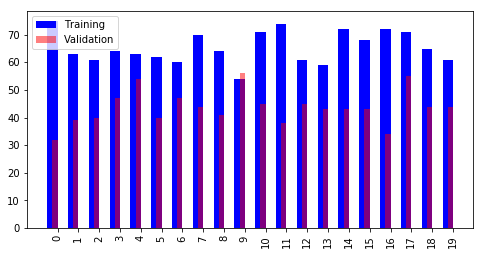

In [6]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from fastai.vision import imagenet_stats, normalize

def nptotorch(x,y, split=0.6, subset=1000, verbose=True, nc=120):
    x_t = torch.tensor(x).transpose(-1,1)
    y_t = torch.tensor(y)
    idx = get_idx(x_t)[:subset]
    loc = int(split * subset)
    if verbose: getHist(y[idx[:loc]], y[idx[loc:]], nc=nc)
    tdl = DataLoader(TensorDataset(normalize(x_t[idx[:loc]].float(),torch.tensor(imagenet_stats[0]),torch.tensor(imagenet_stats[1]))
                               ,y_t[idx[:loc]]
                              ), batch_size = 40)
    vdl = DataLoader(TensorDataset(normalize(x_t[idx[loc:]].float(),torch.tensor(imagenet_stats[0]),torch.tensor(imagenet_stats[1]))
                                   ,y_t[idx[loc:]]
                                  ), batch_size = 40)
    return tdl,vdl


tdl,vdl = nptotorch(x,y, subset=x.shape[0], nc=nc)

Load in pretrained ResNet
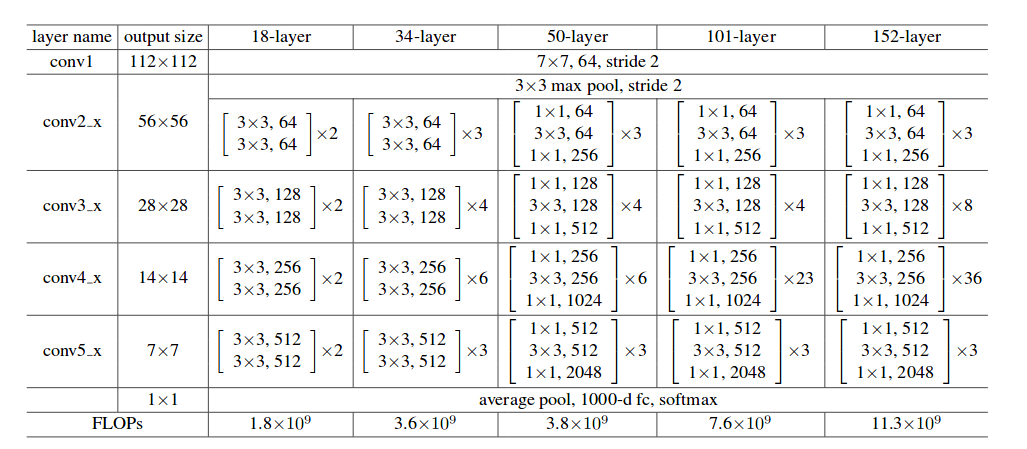

In [7]:
from torchvision.models import resnet34
resnet34()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Freeze our head with torch.no_grad()

### TransferTrainableClassifier Class
    Has the option to apply discrimitative learning rate on transfer learning models.
    It applies a different learning rate on the body and the head.

In [8]:
from progressbar import progressbar

class TransferTrainableClassifier(BasicTrainableClassifier):
    def fit(self, train_ds, valid_ds, cbs=False,
            epochs=1, learning_rate=1e-3, lr_seg = None):
        self.train()
        if lr_seg is not None:
            op = [self.opt(self.body.parameters(), lr=lr_seg[0]), self.opt(self.head.parameters(), lr=lr_seg[1])]
        else: op = self.opt(self.parameters(), lr=learning_rate)
        for e in range(epochs):
            torch.cuda.empty_cache() if torch.cuda.device_count() else None
            for data in progressbar(train_ds):
                op.zero_grad() if lr_seg is None else [o.zero_grad() for o in op]
                pred = self(cc(data[0]))
                loss = self.crit(pred, cc(data[1], self.dtype))
                loss.backward(retain_graph = self.rg)
                op.step()  if lr_seg is None else [o.step() for o in op]
            self.cbs_(e, train_ds, valid_ds=valid_ds) if cbs else None

### Freezing
    This prevents the pretrained model from learning by only aggregating gradients on the head, or the untrained part.
    
### Weight Decay
    Applies L2 regularization, which prevents the weights from being too large.
    This is done by introducing the squared sum of all the weights to the loss function.
    Thus, the optimizer tries to minimize the actual loss function in addition to all the weights.
    
 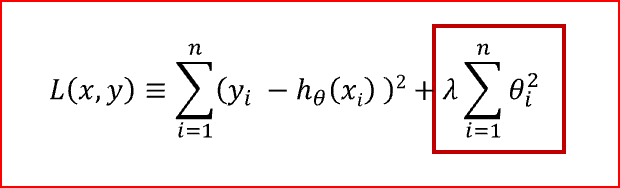

In [9]:
from functools import partial
from fastai.torch_core import Module

def init_Linear(m):
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Linear)): nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)
class noop(Module):
    def __call__(self, x): return x
    
class resCD(TransferTrainableClassifier):
    def __init__(self, nc, frozen=True, **kwargs):
        super().__init__(opt=partial(torch.optim.Adam, weight_decay=1e-2))
        self.body = resnet34(**kwargs); self.body.fc = noop()
        self.head = nn.Sequential(nn.Linear(512,256),
                                  nn.Linear(256,128),
                                  nn.Linear(128,nc))
        self.frozen = frozen
        init_Linear(self)
    def forward(self,x):
        if not self.frozen: return self.head(self.body(x))
        with torch.no_grad(): fm = self.body(x)
        return self.head(fm)
    @property
    def unfreeze(self):
        self.frozen=False
    @property
    def freeze(self):
        self.frozen=True

In [10]:
pt = resCD(nc, pretrained=True).cuda()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /tmp/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 149MB/s]


In [11]:
print(pt.frozen); time.sleep(1)
pt.fit(tdl,vdl,cbs=True,
          epochs=3,learning_rate=1e-3)

True


100% (33 of 33) |########################| Elapsed Time: 0:00:02 Time:  0:00:02
100% (33 of 33) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (22 of 22) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Epoch 1:
	Train Loss: 2.195 | Train Acc: 37.10%
	 Val. Loss: 2.398 |  Val. Acc: 26.28%


100% (33 of 33) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (33 of 33) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (22 of 22) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Epoch 2:
	Train Loss: 1.687 | Train Acc: 49.62%
	 Val. Loss: 2.083 |  Val. Acc: 32.59%


100% (33 of 33) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (33 of 33) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (22 of 22) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Epoch 3:
	Train Loss: 1.393 | Train Acc: 60.13%
	 Val. Loss: 1.962 |  Val. Acc: 36.45%


In [12]:
pt.unfreeze; print(pt.frozen); time.sleep(1)
pt.fit(tdl,vdl,cbs=True,
          epochs=7,lr_seg=[1e-6,1e-4])

False


100% (33 of 33) |########################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (33 of 33) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (22 of 22) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Epoch 1:
	Train Loss: 1.256 | Train Acc: 64.85%
	 Val. Loss: 1.885 |  Val. Acc: 40.05%


100% (33 of 33) |########################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (33 of 33) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (22 of 22) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Epoch 2:
	Train Loss: 1.171 | Train Acc: 67.83%
	 Val. Loss: 1.845 |  Val. Acc: 41.70%


100% (33 of 33) |########################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (33 of 33) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (22 of 22) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Epoch 3:
	Train Loss: 1.094 | Train Acc: 71.19%
	 Val. Loss: 1.816 |  Val. Acc: 43.01%


100% (33 of 33) |########################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (33 of 33) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (22 of 22) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Epoch 4:
	Train Loss: 1.022 | Train Acc: 73.89%
	 Val. Loss: 1.793 |  Val. Acc: 43.35%


100% (33 of 33) |########################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (33 of 33) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (22 of 22) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Epoch 5:
	Train Loss: 0.952 | Train Acc: 76.31%
	 Val. Loss: 1.773 |  Val. Acc: 44.03%


100% (33 of 33) |########################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (33 of 33) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (22 of 22) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Epoch 6:
	Train Loss: 0.885 | Train Acc: 77.40%
	 Val. Loss: 1.757 |  Val. Acc: 44.49%


100% (33 of 33) |########################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (33 of 33) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (22 of 22) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Epoch 7:
	Train Loss: 0.822 | Train Acc: 79.70%
	 Val. Loss: 1.744 |  Val. Acc: 44.83%


In [13]:
npt = resCD(nc, pretrained=False).cuda()

In [14]:
print(npt.frozen);  time.sleep(1)
npt.fit(tdl,vdl,cbs=True,
          epochs=3,learning_rate=1e-3)

True


100% (33 of 33) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (33 of 33) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (22 of 22) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Epoch 1:
	Train Loss: 2.980 | Train Acc: 9.47%
	 Val. Loss: 3.053 |  Val. Acc: 7.92%


100% (33 of 33) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (33 of 33) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (22 of 22) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Epoch 2:
	Train Loss: 2.931 | Train Acc: 8.69%
	 Val. Loss: 2.998 |  Val. Acc: 6.97%


100% (33 of 33) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (33 of 33) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (22 of 22) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Epoch 3:
	Train Loss: 2.926 | Train Acc: 7.78%
	 Val. Loss: 2.987 |  Val. Acc: 6.88%


In [15]:
npt.unfreeze; print(npt.frozen); time.sleep(1)
npt.fit(tdl,vdl,cbs=True,
          epochs=7,lr_seg=[1e-6,1e-4])

False


100% (33 of 33) |########################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (33 of 33) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (22 of 22) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Epoch 1:
	Train Loss: 2.908 | Train Acc: 11.09%
	 Val. Loss: 2.971 |  Val. Acc: 7.54%


100% (33 of 33) |########################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (33 of 33) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (22 of 22) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Epoch 2:
	Train Loss: 2.903 | Train Acc: 10.56%
	 Val. Loss: 2.969 |  Val. Acc: 7.41%


100% (33 of 33) |########################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (33 of 33) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (22 of 22) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Epoch 3:
	Train Loss: 2.899 | Train Acc: 10.78%
	 Val. Loss: 2.968 |  Val. Acc: 7.29%


100% (33 of 33) |########################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (33 of 33) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (22 of 22) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Epoch 4:
	Train Loss: 2.895 | Train Acc: 10.78%
	 Val. Loss: 2.966 |  Val. Acc: 7.52%


100% (33 of 33) |########################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (33 of 33) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (22 of 22) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Epoch 5:
	Train Loss: 2.891 | Train Acc: 11.01%
	 Val. Loss: 2.964 |  Val. Acc: 7.52%


100% (33 of 33) |########################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (33 of 33) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (22 of 22) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Epoch 6:
	Train Loss: 2.886 | Train Acc: 11.46%
	 Val. Loss: 2.962 |  Val. Acc: 7.63%


100% (33 of 33) |########################| Elapsed Time: 0:00:03 Time:  0:00:03
100% (33 of 33) |########################| Elapsed Time: 0:00:01 Time:  0:00:01
100% (22 of 22) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Epoch 7:
	Train Loss: 2.881 | Train Acc: 11.62%
	 Val. Loss: 2.960 |  Val. Acc: 7.75%


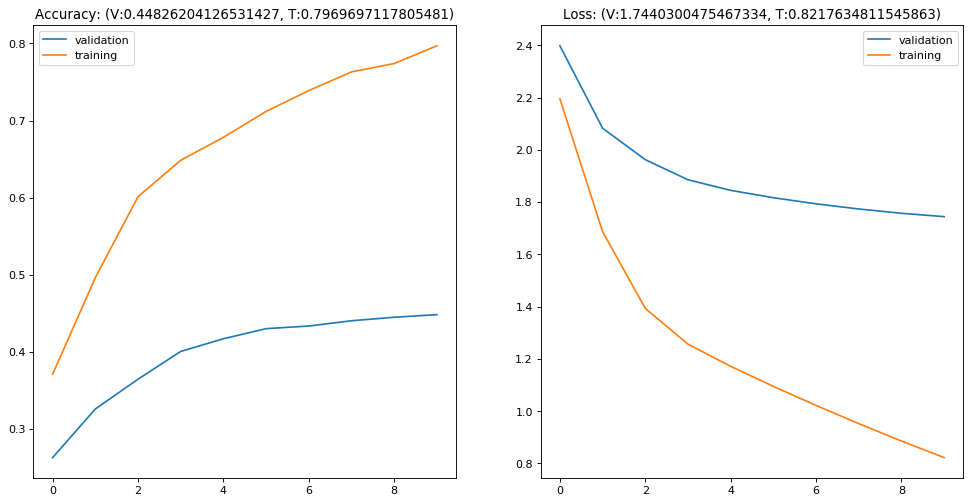

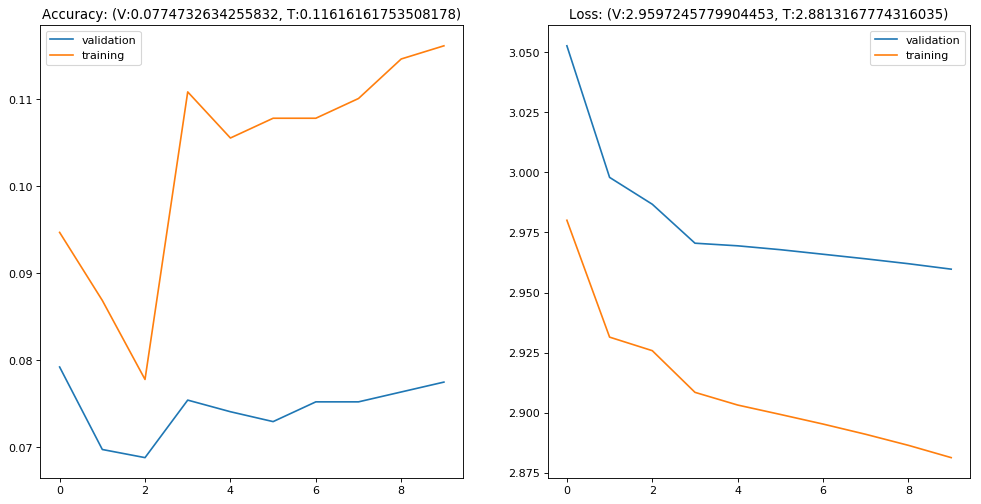

In [16]:
pt.plot;npt.plot